##  Piza Nava Vladimir - 111-494


## Laboratorio 3.1

## Link al repositorio: https://github.com/vladi-13/Laboratorios/blob/main/Laboratorio%203-1.ipynb

## Link al dataset: https://www.kaggle.com/datasets/vladi13/dataset-flores-piza-nava-vladimir

Este código configura el entorno para entrenar una red neuronal en **PyTorch** utilizando **DirectML**, una alternativa a CUDA para GPUs AMD.  

###  Configuración del Dispositivo  
Se obtiene el dispositivo disponible con **DirectML** y se fija una semilla aleatoria (`torch.manual_seed(42)`) para asegurar que los experimentos sean reproducibles.  

###  Mensaje de Confirmación  
Se imprime el dispositivo en uso para verificar que DirectML está funcionando correctamente.  

In [1]:
import os
import random
import torch
import torch_directml
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Configurar el dispositivo DirectML
device = torch_directml.device()
torch.manual_seed(42)  # Para reproducibilidad
print(f"Usando dispositivo: {device}")

Usando dispositivo: privateuseone:0


aEste código realiza las siguientes tareas:

1. **Cargar el dataset**: Lee el archivo CSV que contiene las rutas de las imágenes y sus respectivas etiquetas.
2. **Mapeo de clases**: Crea un diccionario que asigna un índice numérico a cada clase (basado en las etiquetas del CSV).
3. **División de los datos**: Divide los datos en conjuntos de entrenamiento y validación utilizando un 80% para entrenamiento y un 20% para validación, estratificando según las clases para mantener la distribución.
4. **Transformaciones de imágenes**: Define las transformaciones a aplicar a las imágenes, como el cambio de tamaño (64x64) y la normalización de las imágenes con los valores estándar de los modelos preentrenados (como DenseNet).
5. **Definir dataset personalizado**: Crea una clase `FlowerDataset` que se puede usar con PyTorch `DataLoader`, la cual carga las imágenes desde las rutas proporcionadas en el CSV y las convierte a tensores, aplicando las transformaciones.
6. **Crear DataLoaders**: Crea los `DataLoader` para los datos de entrenamiento y validación, especificando el tamaño del lote y el número de workers.
7. **Mostrar tamaños de los datasets**: Imprime el número de muestras en los conjuntos de entrenamiento y validación.

Es útil para cargar, procesar y dividir los datos para entrenamiento en un modelo de clasificación de imágenes.# Explicación General del Código  

- **Carga del dataset** desde un CSV con rutas de imágenes y etiquetas.  
- **Mapeo de clases** a índices numéricos para la red neuronal.  
- **División 80/20** en entrenamiento y validación con estratificación.  
- **Transformaciones**: redimensionado (64x64), conversión a tensor y normalización.  
- **Dataset personalizado** (`FlowerDataset`) para cargar imágenes y aplicar transformaciones.  
- **DataLoaders** para manejar datos en lotes (`batch_size=256`), con mezcla en entrenamiento.  
- **Impresión de datos** para verificar la cantidad en cada conjunto.  

In [2]:
# Cargar dataset
csv_path = "dataset_flores.csv"
data = pd.read_csv(csv_path)

# Crear mapeo de clases
class_names = sorted(data.iloc[:, 1].unique())
class_mapping = {name: idx for idx, name in enumerate(class_names)}
print("Mapa de clases:", class_mapping)

# Separar datos en entrenamiento y validación
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data.iloc[:, 1], random_state=42)

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Tamaño compatible con DenseNet161
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Definición de dataset personalizado
class FlowerDataset(Dataset):
    def __init__(self, csv_data, transform=None):
        self.data = csv_data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data.iloc[index, 0]  # Ruta de la imagen
        label = self.data.iloc[index, 1]     # Clase de la imagen
        label = class_mapping[label]         # Convertir la clase a índice numérico

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Crear datasets y DataLoaders
train_dataset = FlowerDataset(train_data, transform=transform)
val_dataset = FlowerDataset(val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

# Mostrar tamaño de los datasets
print(f"Datos de entrenamiento: {len(train_dataset)}")
print(f"Datos de validación: {len(val_dataset)}")

Mapa de clases: {'Astromelia': 0, 'Cartucho': 1, 'Lirio': 2, 'Obispo': 3, 'SanJuan': 4}
Datos de entrenamiento: 40000
Datos de validación: 10000


Este código implementa **aprendizaje por transferencia** usando `DenseNet161` preentrenado:

1. **Carga el modelo preentrenado** y congela las capas convolucionales para que no se actualicen.
2. **Modifica la capa final** para adaptarla a 5 clases (nuevo conjunto de datos).
3. **Configura el optimizador (`Adam`) y la pérdida (`CrossEntropyLoss`)**.
4. **Implementa Early Stopping** para detener el entrenamiento si la pérdida de validación no mejora después de un número de épocas (`patience`).
5. **Ciclo de entrenamiento**:
   - Se entrena el modelo con los datos de entrenamiento.
   - Se evalúa en el conjunto de validación.
   - Si mejora la pérdida de validación, se guarda el modelo; de lo contrario, se incrementa el contador de Early Stopping.

Se imprime la **precisión** y **pérdida** en cada época, así como el estado del Early Stopping.

In [ ]:
# Cargar modelo preentrenado
model_transfer = models.densenet161(pretrained=True)

# Congelar capas convolucionales
for param in model_transfer.features.parameters():
    param.requires_grad = False # Evita que se actualicen los pesos de las capas convolucionales

# Modificar la capa final para 5 clases
model_transfer.classifier = nn.Linear(model_transfer.classifier.in_features, 5)

# Enviar modelo a DirectML
model_transfer = model_transfer.to(device)

# Configurar optimizador y función de pérdida
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001, weight_decay=1e-4)

# Configurar Early Stopping
epochs = 10
patience = 3
best_val_loss = float("inf")
early_stop_counter = 0

for epoch in range(epochs):
    model_transfer.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Época {epoch+1}/{epochs} [Transfer Learning]", leave=False)

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model_transfer(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validación
    model_transfer.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model_transfer(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_loss /= len(val_loader)

    print(f"\nÉpoca {epoch+1}/{epochs} - Transfer Learning")
    print(f"  Precisión Entrenamiento: {train_accuracy:.2f}% | Pérdida: {train_loss:.4f}")
    print(f"  Precisión Validación: {val_accuracy:.2f}% | Pérdida: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model_transfer.state_dict(), "best_model_transfer.pth")
        print("  🔥 Nuevo mejor modelo guardado (Transfer Learning)!")
    else:
        early_stop_counter += 1
        print(f"  ⏳ Early Stopping Counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("\n🚨 Deteniendo entrenamiento por Early Stopping 🚨")
        break

c:\Users\vladi\OneDrive\Documentos\Universidad\Sexto Semestre\SIS421\Laboratorios\entorno\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vladi\OneDrive\Documentos\Universidad\Sexto Semestre\SIS421\Laboratorios\entorno\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Época 1/10 [Transfer Learning]:   0%|          | 0/157 [00:00<?, ?it/s]c:\Users\vladi\OneDrive\Documentos\Universidad\Sexto Semestre\SIS421\Laboratorios\entorno\lib\site-packages\torch\optim\adam.py:534: UserWarning: The operator 'aten


Época 1/10 - Transfer Learning
  Precisión Entrenamiento: 93.94% | Pérdida: 0.2777
  Precisión Validación: 98.31% | Pérdida: 0.0947
  🔥 Nuevo mejor modelo guardado (Transfer Learning)!



Época 2/10 - Transfer Learning
  Precisión Entrenamiento: 98.60% | Pérdida: 0.0766
  Precisión Validación: 98.84% | Pérdida: 0.0584
  🔥 Nuevo mejor modelo guardado (Transfer Learning)!



Época 3/10 - Transfer Learning
  Precisión Entrenamiento: 99.05% | Pérdida: 0.0516
  Precisión Validación: 99.18% | Pérdida: 0.0441
  🔥 Nuevo mejor modelo guardado (Transfer Learning)!



Época 4/10 - Transfer Learning
  Precisión Entrenamiento: 99.16% | Pérdida: 0.0408
  Precisión Validación: 99.23% | Pérdida: 0.0384
  🔥 Nuevo mejor modelo guardado (Transfer Learning)!



Época 5/10 - Transfer Learning
  Precisión Entrenamiento: 99.31% | Pérdida: 0.0335
  Precisión Validación: 99.25% | Pérdida: 0.0351
  🔥 Nuevo mejor modelo guardado (Transfer Learning)!



Época 6/10 - Transfer Learning
  Precisión Entrenamiento: 99.41% | Pérdida: 0.0286
  Precisión Validación: 99.28% | Pérdida: 0.0313
  🔥 Nuevo mejor modelo guardado (Transfer Learning)!



Época 7/10 - Transfer Learning
  Precisión Entrenamiento: 99.45% | Pérdida: 0.0264
  Precisión Validación: 99.33% | Pérdida: 0.0283
  🔥 Nuevo mejor modelo guardado (Transfer Learning)!



Época 8/10 - Transfer Learning
  Precisión Entrenamiento: 99.55% | Pérdida: 0.0221
  Precisión Validación: 99.39% | Pérdida: 0.0265
  🔥 Nuevo mejor modelo guardado (Transfer Learning)!



Época 9/10 - Transfer Learning
  Precisión Entrenamiento: 99.56% | Pérdida: 0.0208
  Precisión Validación: 99.38% | Pérdida: 0.0288
  ⏳ Early Stopping Counter: 1/3



Época 10/10 - Transfer Learning
  Precisión Entrenamiento: 99.61% | Pérdida: 0.0190
  Precisión Validación: 99.36% | Pérdida: 0.0243
  🔥 Nuevo mejor modelo guardado (Transfer Learning)!


Este código realiza **fine-tuning** sobre un modelo preentrenado `DenseNet161`:

1. **Carga el modelo preentrenado** y **descongela todas las capas** para permitir su ajuste.
2. **Modifica la capa final** para ajustarla a 5 clases (nuevo conjunto de datos).
3. **Configura el optimizador (`Adam`)** y la función de pérdida (`CrossEntropyLoss`).
4. **Ciclo de entrenamiento**:
   - Entrena el modelo con los datos de entrenamiento.
   - Evalúa el modelo en el conjunto de validación.
   - Si la pérdida de validación mejora, guarda el modelo; si no, aumenta el contador de Early Stopping.
5. **Early Stopping**: Detiene el entrenamiento si la pérdida de validación no mejora después de un número determinado de épocas (`patience`).

Se imprime la **precisión** y **pérdida** para cada época.

In [ ]:
# Cargar modelo preentrenado
model_finetune = models.densenet161(pretrained=True)

# Descongelar todas las capas
for param in model_finetune.parameters():
    param.requires_grad = True  # Ahora todas las capas se entrenan

# Modificar la capa final para 5 clases
model_finetune.classifier = nn.Linear(model_finetune.classifier.in_features, 5)

# Enviar modelo a DirectML
model_finetune = model_finetune.to(device)

# Configurar optimizador y función de pérdida
optimizer = optim.Adam(model_finetune.parameters(), lr=0.0001, weight_decay=1e-4)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False, num_workers=0)

# Configurar Early Stopping
epochs = 5
patience = 2
best_val_loss = float("inf")
early_stop_counter = 0

for epoch in range(epochs):
    model_finetune.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Época {epoch+1}/{epochs} [Fine-Tuning]", leave=False)

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model_finetune(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validación
    model_finetune.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model_finetune(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_loss /= len(val_loader)

    print(f"\nÉpoca {epoch+1}/{epochs} - Fine-Tuning")
    print(f"  Precisión Entrenamiento: {train_accuracy:.2f}% | Pérdida: {train_loss:.4f}")
    print(f"  Precisión Validación: {val_accuracy:.2f}% | Pérdida: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model_finetune.state_dict(), "best_model_finetune.pth")
        print("  🔥 Nuevo mejor modelo guardado (Fine-Tuning)!")
    else:
        early_stop_counter += 1
        print(f"  ⏳ Early Stopping Counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("\n🚨 Deteniendo entrenamiento por Early Stopping 🚨")
        break


Época 1/5 - Fine-Tuning
  Precisión Entrenamiento: 99.23% | Pérdida: 0.0315
  Precisión Validación: 99.86% | Pérdida: 0.0056
  🔥 Nuevo mejor modelo guardado (Fine-Tuning)!



Época 2/5 - Fine-Tuning
  Precisión Entrenamiento: 99.85% | Pérdida: 0.0060
  Precisión Validación: 99.89% | Pérdida: 0.0033
  🔥 Nuevo mejor modelo guardado (Fine-Tuning)!



Época 3/5 - Fine-Tuning
  Precisión Entrenamiento: 99.80% | Pérdida: 0.0078
  Precisión Validación: 99.92% | Pérdida: 0.0027
  🔥 Nuevo mejor modelo guardado (Fine-Tuning)!



Época 4/5 - Fine-Tuning
  Precisión Entrenamiento: 99.93% | Pérdida: 0.0027
  Precisión Validación: 99.89% | Pérdida: 0.0037
  ⏳ Early Stopping Counter: 1/2



Época 5/5 - Fine-Tuning
  Precisión Entrenamiento: 99.85% | Pérdida: 0.0060
  Precisión Validación: 99.93% | Pérdida: 0.0031
  ⏳ Early Stopping Counter: 2/2

🚨 Deteniendo entrenamiento por Early Stopping 🚨


Este código carga dos modelos preentrenados (`Transfer Learning` y `Fine-Tuning`) y los evalúa en un conjunto de validación. Aquí está el resumen:

1. **Función `cargar_modelo`**:
   - Carga un modelo `DenseNet161` sin pesos preentrenados.
   - Ajusta la última capa para clasificar en 5 clases.
   - Carga los pesos del modelo desde el archivo y lo pone en modo de evaluación.

2. **Evaluación de los modelos**:
   - Para cada modelo (`Transfer Learning` y `Fine-Tuning`), se evalúa su rendimiento en un conjunto de validación, calculando la **precisión** y la **pérdida promedio**.
   
3. **Mostrar resultados**:
   - Para cada modelo, se imprime la **precisión** y la **pérdida promedio** durante la evaluación.

Este enfoque permite comparar el desempeño de ambos modelos en el mismo conjunto de validación.

In [11]:
import torch
from torchvision import models
import torch.nn as nn

# Cargar los modelos guardados
def cargar_modelo(ruta_modelo, device):
    """Carga un modelo DenseNet con pesos preentrenados y la última capa ajustada."""
    model = models.densenet161(pretrained=False)
    model.classifier = nn.Linear(model.classifier.in_features, 5)  # 5 clases
    model.load_state_dict(torch.load(ruta_modelo, map_location=device))
    model.to(device)
    model.eval()  # Cambiar a modo evaluación
    return model

# Cargar modelos de Transfer Learning y Fine-Tuning
model_transfer = cargar_modelo("best_model_transfer.pth", device)
model_finetune = cargar_modelo("best_model_finetune.pth", device)

# Función de evaluación
def evaluar_modelo(model, val_loader, criterion, device, nombre_modelo):
    """Evalúa el modelo en un conjunto de validación."""
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No calcular gradientes
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total  # Precisión
    avg_loss = total_loss / len(val_loader)  # Pérdida promedio

    # Mostrar los resultados
    print(f'{nombre_modelo}: Precisión: {accuracy:.2f}% - Pérdida Promedio: {avg_loss:.4f}')
    return accuracy, avg_loss

# Evaluar ambos modelos
accuracy_transfer, loss_transfer = evaluar_modelo(model_transfer, val_loader, criterion, device, "Transfer Learning")
accuracy_finetune, loss_finetune = evaluar_modelo(model_finetune, val_loader, criterion, device, "Fine-Tuning")

c:\Users\vladi\OneDrive\Documentos\Universidad\Sexto Semestre\SIS421\Laboratorios\entorno\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\vladi\AppData\Local\Temp\ipykernel_11032\1952723348.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unles

Transfer Learning: Precisión: 99.36% - Pérdida Promedio: 0.0246
Fine-Tuning: Precisión: 99.92% - Pérdida Promedio: 0.0027


Este código realiza lo siguiente:

1. **Funciones principales**:
   - **`elegir_imagen_aleatoria`**: Selecciona aleatoriamente una imagen desde un archivo CSV que contiene las rutas y las clases de las imágenes.
   - **`predecir_imagen`**: Carga una imagen, la transforma para que sea compatible con el modelo y luego realiza una predicción usando el modelo. Devuelve la imagen y la predicción.
   - **`cargar_modelo`**: Carga un modelo DenseNet preentrenado con pesos ajustados para 5 clases, y lo prepara para su uso en evaluación.

2. **Carga de modelos**:
   - Se cargan dos modelos previamente entrenados: uno con **Transfer Learning** y otro con **Fine-Tuning**.

3. **Predicción y visualización**:
   - Se selecciona una imagen aleatoria desde el CSV, se predice la clase con ambos modelos, y se muestra la imagen junto con las predicciones de ambos modelos y la clase real.

El flujo permite comparar las predicciones de dos enfoques de entrenamiento (Transfer Learning y Fine-Tuning) para una imagen seleccionada aleatoriamente.

c:\Users\vladi\OneDrive\Documentos\Universidad\Sexto Semestre\SIS421\Laboratorios\entorno\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vladi\OneDrive\Documentos\Universidad\Sexto Semestre\SIS421\Laboratorios\entorno\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\vladi\AppData\Local\Temp\ipykernel_11032\3998984062.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch

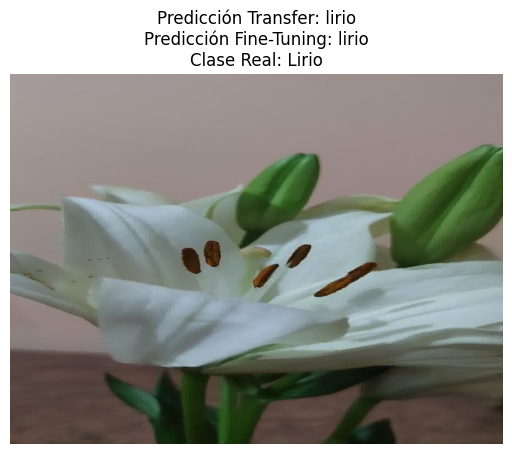

In [31]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Lista de clases
class_names = ["astromelia", "cartucho", "lirio", "obispo", "sanjuan"]

# Función para elegir una imagen aleatoria desde el CSV
def elegir_imagen_aleatoria(csv_path="dataset_flores.csv"):
    """Selecciona aleatoriamente una imagen desde un CSV con rutas y clases."""
    df = pd.read_csv(csv_path)
    
    if df.empty:
        return None, None
    
    fila = df.sample(n=1).iloc[0]  # Seleccionar una fila aleatoria
    return fila["image_path"], fila["label"]

# Función para predecir una imagen usando un modelo
def predecir_imagen(model, image_path, class_names, device):
    """Carga una imagen, la pasa por el modelo y devuelve la predicción."""
    image = Image.open(image_path).convert("RGB")  # Cargar la imagen
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Asegúrate que el tamaño sea compatible con el modelo
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)  # Aplicar transformaciones

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

    prediccion = class_names[predicted.item()]  # Convertir índice a nombre de clase
    return image, prediccion

# Cargar los modelos guardados
def cargar_modelo(ruta_modelo, device):
    """Carga un modelo DenseNet con pesos preentrenados y la última capa ajustada."""
    model = models.densenet161(pretrained=False)
    model.classifier = nn.Linear(model.classifier.in_features, 5)  # 5 clases
    model.load_state_dict(torch.load(ruta_modelo, map_location=device))
    model.to(device)
    model.eval()  # Cambiar a modo evaluación
    return model

# Cargar modelos de Transfer Learning y Fine-Tuning
model_transfer = cargar_modelo("best_model_transfer.pth", device)
model_finetune = cargar_modelo("best_model_finetune.pth", device)

# Predecir una imagen aleatoria desde el CSV
image_path, clase_real = elegir_imagen_aleatoria("dataset_flores.csv")
if image_path:
    # Predecir con ambos modelos
    image, pred_transfer = predecir_imagen(model_transfer, image_path, class_names, device)
    _, pred_finetune = predecir_imagen(model_finetune, image_path, class_names, device)

    # Mostrar la imagen con sus predicciones y la clase real
    plt.imshow(image)
    plt.title(f'Predicción Transfer: {pred_transfer}\nPredicción Fine-Tuning: {pred_finetune}\nClase Real: {clase_real}')
    plt.axis('off')
    plt.show()
else:
    print("No se encontraron imágenes en el CSV.")